<a href="https://colab.research.google.com/github/SZ330/EE344-Assignment-2/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Part 1: Outlier Detection and Removal using Cook's Distance**

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import OLSInfluence

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.set_printoptions(precision=4, suppress=True)

In [48]:
def fit_ols_diagnostics(X, y):
    """Fit OLS and return (model, diagnostics dataframe).

    Parameters
    ----------
    X : array-like, shape (n,) or (n, p)
        Feature matrix (without intercept column).
    y : array-like, shape (n,)
        Target vector.
    """
    X = np.asarray(X)
    y = np.asarray(y).reshape(-1)
    if X.ndim == 1:
        X = X.reshape(-1, 1)

    # Add intercept column for statsmodels
    X_sm = sm.add_constant(X)
    model = sm.OLS(y, X_sm).fit()

    infl = OLSInfluence(model)
    diag = pd.DataFrame({
        "y": y,
        "y_hat": model.fittedvalues,
        "residual": model.resid,
        "leverage_hii": infl.hat_matrix_diag,   # diagonal of Hat matrix H
        "cooks_D": infl.cooks_distance[0]
    })
    return model, diag

def plot_curve_fit(x, y, pipeline, title=""):
    """Scatter + fitted curve for scikit-learn pipeline (1D x)."""
    x = np.asarray(x).reshape(-1, 1)
    y = np.asarray(y).reshape(-1)

    # Create a smooth grid for plotting
    grid = np.linspace(x.min(), x.max(), 200).reshape(-1, 1)
    yhat = pipeline.predict(grid)

    plt.figure(figsize=(7, 4))
    plt.scatter(x, y)
    plt.plot(grid, yhat)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.show()

In [49]:
# Use usina_with_outliers.csv (multivariate predictors)
df = pd.read_csv("usina_with_outliers.csv")
print("Rows loaded:", df.shape[0])
print("Columns:", df.columns.tolist())
FEATURE_COLS = ["AT", "V", "AP", "RH"]
TARGET_COL = "PE"

# Drop missing rows
df_clean_in = df.dropna().copy()

X = df_clean_in[FEATURE_COLS]
y = df_clean_in[TARGET_COL]

model_full, diag_full = fit_ols_diagnostics(X, y)

print(model_full.summary())

# Cook's distance threshold
n = len(df_clean_in)
threshold = 4 / n

diag_table = diag_full.copy()
diag_table["flag_D_gt_4_over_n"] = diag_table["cooks_D"] > threshold

print(f"Cook's distance heuristic threshold 4/n = {threshold:.6f}")

# Show the top points by Cook's distance
diag_table_sorted = diag_table.sort_values("cooks_D", ascending=False)
display(diag_table_sorted.head(15))
display(diag_table_sorted.tail(15))


Rows loaded: 9568
Columns: ['AT', 'V', 'AP', 'RH', 'PE']
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.649
Method:                 Least Squares   F-statistic:                     4416.
Date:                Thu, 29 Jan 2026   Prob (F-statistic):               0.00
Time:                        18:59:40   Log-Likelihood:                -36621.
No. Observations:                9568   AIC:                         7.325e+04
Df Residuals:                    9563   BIC:                         7.329e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

,y,y_hat,residual,leverage_hii,cooks_D,flag_D_gt_4_over_n
4228,532.89197,367.627618,165.264352,0.027485,1.283760,True
49,370.64803,515.833750,-145.185720,0.027817,1.003422,True
875,541.43197,408.524788,132.907182,0.032505,0.992133,True
5922,373.10803,481.504793,-108.396763,0.041859,0.866516,True
2538,364.32803,559.133964,-194.805934,0.013496,0.851224,True
5480,358.96803,505.177891,-146.209861,0.023388,0.847862,True
9241,575.06197,410.364058,164.697912,0.017632,0.801592,True
7678,331.77803,476.209310,-144.431280,0.022602,0.798247,True
9525,343.19803,472.982395,-129.784365,0.026271,0.754847,True
9219,536.88197,394.454473,142.427497,0.019136,0.652604,True


,y,y_hat,residual,leverage_hii,cooks_D,flag_D_gt_4_over_n
3139,448.87,448.877793,-0.007793,0.000445,4.372253e-11,False
2373,463.65,463.656325,-0.006325,0.000649,4.204544e-11,False
9058,442.67,442.679633,-0.009633,0.000206,3.097179e-11,False
160,448.37,448.379786,-0.009786,0.000194,3.012523e-11,False
8950,431.19,431.194679,-0.004679,0.000817,2.897086e-11,False
3033,456.88,456.890712,-0.010712,0.000148,2.739085e-11,False
2245,449.34,449.349007,-0.009007,0.000206,2.702788e-11,False
3926,451.44,451.436356,0.003644,0.000392,8.434416e-12,False
871,433.62,433.624036,-0.004036,0.000308,8.116194e-12,False
7255,440.96,440.962203,-0.002203,0.000626,4.919034e-12,False


In [50]:
# Keep only non-outlier observations
mask_keep = ~diag_table["flag_D_gt_4_over_n"]

df_no_outliers = df_clean_in.loc[mask_keep].copy()
print("Original rows:", df_clean_in.shape[0])
print("Outliers removed:", (~mask_keep).sum())
print("Cleaned rows:", df_no_outliers.shape[0])

df_no_outliers.to_csv("usina.csv", index=False)
print("Saved cleaned dataset as usina.csv")

Original rows: 9568
Outliers removed: 120
Cleaned rows: 9448
Saved cleaned dataset as usina.csv


**Q1 Discussion**:
I chose to use linear regression because Cook's distance was designed to work with linear regression models. Cook's distance is used to identify influential data points that heavily change the model's fitted values. I also chose to use OLS because it is an estimation that Cook's distance is based on.

# **Part 2: Train/Test Evaluation Before vs After Outlier Removal**

In [51]:
# Dataset with outliers
df_with = pd.read_csv("usina_with_outliers.csv")
print("WITH outliers")
print("Shape:", df_with.shape)
display(df_with.head())
target_with = df_with.columns[-1]
print("Target column:", target_with)

# Dataset without outliers
df_without = pd.read_csv("usina.csv")
print("\nWITHOUT outliers")
print("Shape:", df_without.shape)
display(df_without.head())
target_without = df_without.columns[-1]
print("Target column:", target_without)

WITH outliers
Shape: (9568, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Target column: PE

WITHOUT outliers
Shape: (9448, 5)


,AT,V,AP,RH,PE
0,14.96,41.76,1024.07,73.17,463.26
1,25.18,62.96,1020.04,59.08,444.37
2,5.11,39.40,1012.16,92.14,488.56
3,20.86,57.32,1010.24,76.64,446.48
4,10.82,37.50,1009.23,96.62,473.90


Target column: PE


In [52]:
target_with = df_with.columns[-1]

X_with = df_with.drop(columns=[target_with]).copy()
y_with = df_with[target_with].values.reshape(-1, 1)
X_train_with, X_test_with, y_train_with, y_test_with = train_test_split(
    X_with, y_with, test_size=0.30, random_state=42, shuffle=True
)
print("WITH outliers")
print("Train:", X_train_with.shape, y_train_with.shape)
print("Test :", X_test_with.shape, y_test_with.shape)

target_without = df_without.columns[-1]
X_without = df_without.drop(columns=[target_without]).copy()
y_without = df_without[target_without].values.reshape(-1, 1)
X_train_without, X_test_without, y_train_without, y_test_without = train_test_split(
    X_without, y_without, test_size=0.30, random_state=42, shuffle=True
)
print("\nWITHOUT outliers")
print("Train:", X_train_without.shape, y_train_without.shape)
print("Test :", X_test_without.shape, y_test_without.shape)

WITH outliers
Train: (6697, 4) (6697, 1)
Test : (2871, 4) (2871, 1)

WITHOUT outliers
Train: (6613, 4) (6613, 1)
Test : (2835, 4) (2835, 1)


In [53]:
# WITH outliers
X_train_with_un = X_train_with.values
X_test_with_un  = X_test_with.values
y_train_with_un = y_train_with
y_test_with_un  = y_test_with

feature_names_with = X_train_with.columns.tolist()

# WITHOUT outliers
X_train_without_un = X_train_without.values
X_test_without_un  = X_test_without.values
y_train_without_un = y_train_without
y_test_without_un  = y_test_without

feature_names_without = X_train_without.columns.tolist()

# Scaled (fit scalers only on TRAIN)
x_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train_sc = x_scaler.fit_transform(X_train_without_un)
X_test_sc  = x_scaler.transform(X_test_without_un)

y_train_sc = y_scaler.fit_transform(y_train_without_un)
y_test_sc  = y_scaler.transform(y_test_without_un)

feature_names_scaled = X.columns.tolist()

In [54]:
lambda_grid = [0.01, 0.1, 1, 10, 100]

def eval_metrics(y_true, y_pred):
    y_true = y_true.reshape(-1)
    y_pred = y_pred.reshape(-1)
    return {
        "mse": mean_squared_error(y_true, y_pred),
        "mae": mean_absolute_error(y_true, y_pred),
        "r2":  r2_score(y_true, y_pred),
    }

def sweep_model(model_type: str, scenario: str, lambda_grid):
    # Pick the correct dataset
    if scenario == "with":
        Xt_tr, Xt_te = X_train_with_un, X_test_with_un
        yt_tr, yt_te = y_train_with_un, y_test_with_un
    elif scenario == "without":
        Xt_tr, Xt_te = X_train_without_un, X_test_without_un
        yt_tr, yt_te = y_train_without_un, y_test_without_un
    else:
        raise ValueError("scenario must be 'with' or 'without'")

    rows = []
    for lam in lambda_grid:
        lam = float(lam)

        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)
        else:
            raise ValueError("model_type must be 'Ridge' or 'Lasso'")

        model.fit(Xt_tr, np.ravel(yt_tr))

        pred_tr = model.predict(Xt_tr).reshape(-1, 1)
        pred_te = model.predict(Xt_te).reshape(-1, 1)

        mtr = eval_metrics(yt_tr, pred_tr)
        mte = eval_metrics(yt_te, pred_te)

        rows.append({
            "scenario": scenario,
            "model": model_type,
            "lambda": lam,
            **{f"train_{k}": v for k, v in mtr.items()},
            **{f"test_{k}": v for k, v in mte.items()},
        })

    return pd.DataFrame(rows).reset_index(drop=True)

def run_linear_regression(scenario: str):
    if scenario == "with":
        Xt_tr, Xt_te = X_train_with_un, X_test_with_un
        yt_tr, yt_te = y_train_with_un, y_test_with_un
    elif scenario == "without":
        Xt_tr, Xt_te = X_train_without_un, X_test_without_un
        yt_tr, yt_te = y_train_without_un, y_test_without_un
    else:
        raise ValueError("scenario must be 'with' or 'without'")

    model = LinearRegression()
    model.fit(Xt_tr, np.ravel(yt_tr))

    pred_tr = model.predict(Xt_tr).reshape(-1, 1)
    pred_te = model.predict(Xt_te).reshape(-1, 1)

    mtr = eval_metrics(yt_tr, pred_tr)
    mte = eval_metrics(yt_te, pred_te)

    return pd.DataFrame([{
        "scenario": scenario,
        "model": "Linear",
        "lambda": "N/A",
        **{f"train_{k}": v for k, v in mtr.items()},
        **{f"test_{k}": v for k, v in mte.items()},
    }])
linear_with = run_linear_regression("with")
linear_without = run_linear_regression("without")

linear_results = pd.concat([linear_with, linear_without], ignore_index=True)

ridge_with = sweep_model("Ridge", "with", lambda_grid)
ridge_without = sweep_model("Ridge", "without", lambda_grid)

lasso_with = sweep_model("Lasso", "with", lambda_grid)
lasso_without = sweep_model("Lasso", "without", lambda_grid)

display(ridge_with)
display(ridge_without)
display(lasso_with)
display(lasso_without)
display(linear_results)

,scenario,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,with,Ridge,0.01,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,with,Ridge,0.10,123.384207,5.198680,0.650171,125.113392,5.052459,0.642574
2,with,Ridge,1.00,123.384207,5.198685,0.650171,125.113421,5.052463,0.642574
3,with,Ridge,10.00,123.384207,5.198737,0.650171,125.113705,5.052513,0.642573
4,with,Ridge,100.00,123.384213,5.199261,0.650171,125.116548,5.053003,0.642565


,scenario,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,without,Ridge,0.01,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302
1,without,Ridge,0.10,19.864671,3.596397,0.931369,20.396770,3.624773,0.930302
2,without,Ridge,1.00,19.864671,3.596400,0.931369,20.396750,3.624774,0.930302
3,without,Ridge,10.00,19.864672,3.596430,0.931369,20.396549,3.624783,0.930303
4,without,Ridge,100.00,19.864758,3.596742,0.931369,20.394626,3.624880,0.930310


,scenario,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,with,Lasso,0.01,123.384210,5.198858,0.650171,125.115332,5.052626,0.642568
1,with,Lasso,0.10,123.384607,5.201739,0.650169,125.134495,5.055348,0.642514
2,with,Lasso,1.00,123.421151,5.229507,0.650066,125.338356,5.083092,0.641931
3,with,Lasso,10.00,126.141514,5.540418,0.642353,128.902136,5.408803,0.631750
4,with,Lasso,100.00,234.655937,11.285489,0.334683,233.064336,11.258653,0.334178


,scenario,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,without,Lasso,0.01,19.864675,3.596368,0.931369,20.396738,3.624754,0.930302
1,without,Lasso,0.10,19.865263,3.596855,0.931367,20.392600,3.624890,0.930316
2,without,Lasso,1.00,19.929852,3.605523,0.931144,20.414755,3.631153,0.930241
3,without,Lasso,10.00,25.685683,4.086632,0.911258,26.157253,4.120464,0.910618
4,without,Lasso,100.00,132.056336,9.482307,0.543756,132.148253,9.523550,0.548436


,scenario,model,lambda,train_mse,train_mae,train_r2,test_mse,test_mae,test_r2
0,with,Linear,N/A,123.384207,5.198679,0.650171,125.113389,5.052458,0.642574
1,without,Linear,N/A,19.864671,3.596396,0.931369,20.396772,3.624773,0.930302


**Q2 Discussion**: Outliers do change the train and test error. If we compare the general train and test values, there is quite a big difference between usina_with_outliers and usina. The dataset without outliers show better generalization. Outliers cause the model to accomodate extreme values and introduce noise, reducing the performance. From the generated data, it seems that Ridge/Lasso do not help improve too much.

# **Part 3: Reliability of Coefficients**

In [55]:
X_sm = sm.add_constant(X_train_without_un)
ols = y_train_without_un

ols_model = sm.OLS(ols, X_sm).fit()

ols_table = pd.DataFrame({
    "term": ["const"] + feature_names_without,
    "coefficient": ols_model.params,
    "t_value": ols_model.tvalues,
    "p_value": ols_model.pvalues
}).sort_values("t_value", key=np.abs, ascending=False)

display(ols_table)

,term,coefficient,t_value,p_value
1,AT,-1.966193,-108.971834,0.000000e+00
0,const,443.753358,38.455715,3.717392e-292
4,RH,-0.150944,-31.237663,6.360165e-200
2,V,-0.234557,-27.390969,1.487453e-156
3,AP,0.072105,6.438038,1.295207e-10


**Q3 Discussion:** I chose Linear Regression with Statmodels OLS. Linear regression gives us a simple and direct coefficients that allow us to look at relationships. I chose to use Statmodels OLS because it provides a more detailed output and statistical measures. I would not scale either because when we scale, we change the scale of the coefficients. Since we are looking at the coefficients to understand them instead of optimizing our results, there is no point of scaling. The most reliable beta is AP (0.072105) and the least reliable beta is AT (-1.966193).  

# **Part 4: Most Important vs Least Important Features**

In [67]:
def standardized_coef_scaled(beta, X_train_raw, y_train_raw):
    """Standardized coefficients (effect size) for scaled data:
       beta_std = beta * (std(X)/std(y)), computed using TRAIN statistics.
    """
    std_x = np.std(X_train_raw, axis=0, ddof=0)
    y_flat = np.ravel(y_train_raw)
    std_y = std_y = np.std(y_flat, ddof=0)
    std_y = std_y if std_y > 0 else 1.0
    return beta * (std_x / std_y)

variant = "scaled"
def linear_with_ols_reports():
    reports = {}
    for variant in ["scaled"]:

        Xt_tr, Xt_te = X_train_sc, X_test_sc
        yt_tr = y_train_without_un

        lr = LinearRegression()
        lr.fit(Xt_tr, yt_tr.ravel())

        # Standardized coefficients
        beta = lr.coef_.reshape(-1)
        beta_std = standardized_coef_scaled(beta, Xt_tr, yt_tr)

        coef_table = pd.DataFrame({
            "feature": feature_names_scaled,
            "coef_value": beta,
            "standardized_coef": beta_std
        }).sort_values("standardized_coef", key=np.abs, ascending=False).reset_index(drop=True)

        reports["scaled"] = {
            "coef_table": coef_table,
        }

    return reports
lin_reports = linear_with_ols_reports()
print("\nStandardized coefficients:")
display(lin_reports[variant]["coef_table"])


Standardized coefficients:


,feature,coef_value,standardized_coef
0,AT,-14.637188,-0.860352
1,V,-2.979022,-0.175103
2,RH,-2.230954,-0.131132
3,AP,0.428372,0.025179


**Q4 Discussion:** I chose to scale the IV since we want to find the most and least important features while the target doesn't really matter as much. In addition, I used linear regression and OLS for my analysis. Linear and OLS can be used to determine the impact of each predictor. Features with larger absolute coefficients would have a greater impact on the result. If we look at AT, it has the greatest standardized coefficient so it is most important while AP has the lowest standardized coefficient, making it the least important.

# **Part 5: Regularization Paths**

In [57]:
lambda_grid_5 = np.logspace(-2, 2, 100)

In [64]:
def sweep_model_scaled(model_type: str, scenario: str, lambda_grid_5):
    if scenario == "with":
        Xt_tr, Xt_te = X_train_sc, X_test_sc
        yt_tr, yt_te = y_train_with_un, y_test_with_un
    elif scenario == "without":
        Xt_tr, Xt_te = X_train_sc, X_test_sc
        yt_tr, yt_te = y_train_without_un, y_test_without_un
    else:
        raise ValueError("scenario must be 'with' or 'without'")

    rows = []
    for lam in lambda_grid_5:
        lam = float(lam)

        if model_type == "Ridge":
            model = Ridge(alpha=lam, random_state=42)
        elif model_type == "Lasso":
            model = Lasso(alpha=lam, max_iter=50000, random_state=42)

        model.fit(Xt_tr, yt_tr.ravel())

        rows.append({
            "scenario": scenario,
            "model": model_type,
            "lambda": lam,
            **{f"coef_{i}": c for i, c in enumerate(model.coef_)}
        })

    return pd.DataFrame(rows)
ridge_sc = sweep_model_scaled("Ridge", "without", lambda_grid_5)
lasso_sc = sweep_model_scaled("Lasso", "without", lambda_grid_5)

display(ridge_sc.head())
display(ridge_sc.tail())
display(lasso_sc.head())
display(lasso_sc.tail())

,scenario,model,lambda,coef_0,coef_1,coef_2,coef_3
0,without,Ridge,0.010000,-14.637067,-2.979094,0.428399,-2.230911
1,without,Ridge,0.010975,-14.637056,-2.979101,0.428401,-2.230907
2,without,Ridge,0.012045,-14.637043,-2.979109,0.428404,-2.230903
3,without,Ridge,0.013219,-14.637028,-2.979118,0.428407,-2.230898
4,without,Ridge,0.014508,-14.637013,-2.979127,0.428411,-2.230892


,scenario,model,lambda,coef_0,coef_1,coef_2,coef_3
95,without,Ridge,68.926121,-13.879471,-3.426493,0.595865,-1.958656
96,without,Ridge,75.646333,-13.812656,-3.465070,0.610758,-1.934470
97,without,Ridge,83.021757,-13.740614,-3.506489,0.626839,-1.908358
98,without,Ridge,91.116276,-13.663054,-3.550874,0.644180,-1.880206
99,without,Ridge,100.000000,-13.579690,-3.598335,0.662850,-1.849901


,scenario,model,lambda,coef_0,coef_1,coef_2,coef_3
0,without,Lasso,0.010000,-14.615175,-2.982157,0.426046,-2.209688
1,without,Lasso,0.010975,-14.612554,-2.982747,0.425923,-2.207458
2,without,Lasso,0.012045,-14.609678,-2.983393,0.425788,-2.205010
3,without,Lasso,0.013219,-14.606521,-2.984103,0.425641,-2.202324
4,without,Lasso,0.014508,-14.603057,-2.984882,0.425479,-2.199376


,scenario,model,lambda,coef_0,coef_1,coef_2,coef_3
95,without,Lasso,68.926121,-0.0,-0.0,0.0,0.0
96,without,Lasso,75.646333,-0.0,-0.0,0.0,0.0
97,without,Lasso,83.021757,-0.0,-0.0,0.0,0.0
98,without,Lasso,91.116276,-0.0,-0.0,0.0,0.0
99,without,Lasso,100.000000,-0.0,-0.0,0.0,0.0


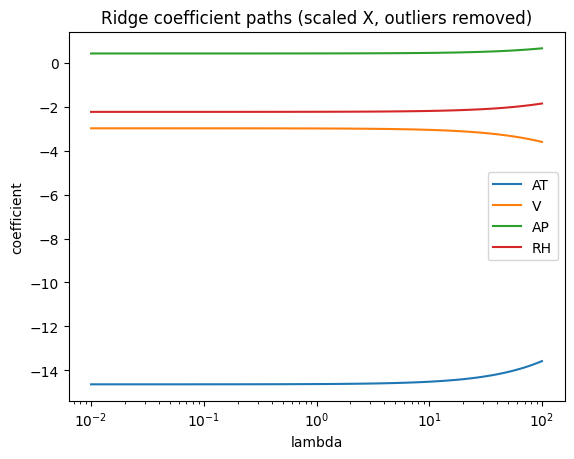

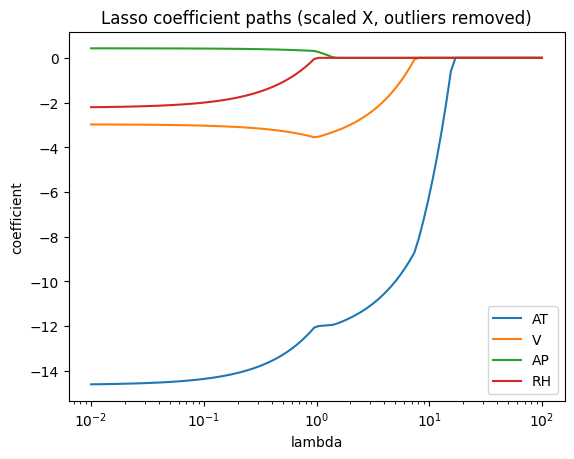

In [66]:
def plot_coef_paths(df, feature_names, title):
    plt.figure()
    for j, name in enumerate(feature_names):
        plt.plot(df["lambda"], df[f"coef_{j}"], label=name)
    plt.xscale("log")
    plt.xlabel("lambda")
    plt.ylabel("coefficient")
    plt.title(title)
    plt.legend()
    plt.show()

plot_coef_paths(ridge_sc, feature_names_scaled, "Ridge coefficient paths (scaled X, outliers removed)")
plot_coef_paths(lasso_sc, feature_names_scaled, "Lasso coefficient paths (scaled X, outliers removed)")

**Q5 Discussion:** If we look at Ridge, as we increase lambda, 3/4 of the coefficints increase while the last coefficient sees a decrease. In Lasso, when we increase lambda, the coefficients all decrease and eventually reach 0. Ridge regression is better for multicollinearity because coefficients remain non-zero and adjust smoothly as λ increases, unlike Lasso. However, Lasso is better for feature selection because coefficients become zero when we increase lambda so it removes irrelevant features from the model.